In [1]:
%matplotlib inline
from __future__ import division
import h5py
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import brownian.bayes as s
from brownian import calc_P_x0, Pf, u
from freqdemod import h5ls

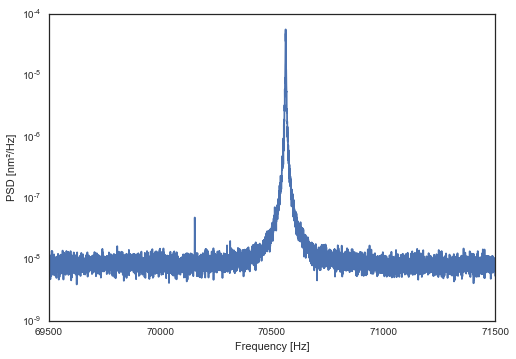

In [2]:
fh = h5py.File('brownian173033.h5', 'r')
f = fh['x'][:]
m = (f > 69500) & (f < 71500)
plt.semilogy(fh['x'][m], fh['y'][m])
plt.xlabel("Frequency [Hz]")
plt.ylabel(u"PSD [nm²/Hz]")

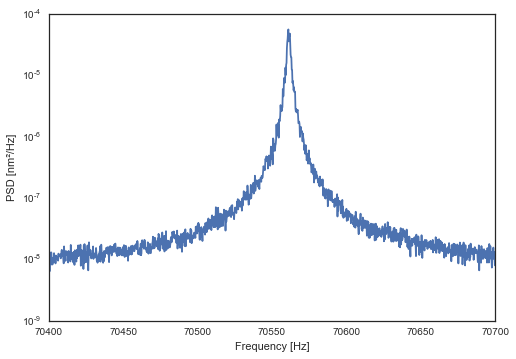

In [3]:
f = fh['x'][:]
m = (f > 70400) & (f < 70700)
plt.semilogy(fh['x'][m], fh['y'][m])
plt.xlabel("Frequency [Hz]")
plt.ylabel(u"PSD [nm²/Hz]")

In [4]:
d = s.fh2data(fh, 70400, 70700, 3.5, 20000, sigma_Q=15000, Pdet=1e-8, sigma_Pdet=3e-8, sigma_kc=2.5)

In [67]:
bp = s.BayesianPyMC3(d)

Applied log-transform to Q and added transformed Q_log_ to model.
Applied log-transform to Pdet and added transformed Pdet_log_ to model.
Applied log-transform to kc and added transformed kc_log_ to model.


In [69]:
%time MAP = pm.find_MAP(model=bp.model)

CPU times: user 74.1 ms, sys: 10.9 ms, total: 85 ms
Wall time: 76.7 ms


In [75]:
%time pm.find_hessian(MAP, model=bp.model,)

CPU times: user 3.23 ms, sys: 325 µs, total: 3.55 ms
Wall time: 3.31 ms


array([[  6.34416804e+02,   4.60897236e+00,  -6.54603987e+00,
          4.58282630e+00],
       [  4.60897236e+00,   1.71939894e+04,  -6.69553557e+03,
          1.71826259e+04],
       [ -6.54603987e+00,  -6.69553557e+03,   6.82755501e+03,
         -6.70105327e+03],
       [  4.58282630e+00,   1.71826259e+04,  -6.70105327e+03,
          1.81403651e+04]])

In [66]:
%time bp.approx()

CPU times: user 54.2 s, sys: 988 ms, total: 55.2 s
Wall time: 55.1 s


array([[  6.34416804e+02,   4.60897236e+00,  -6.54603987e+00,
          4.58282630e+00],
       [  4.60897236e+00,   1.71939894e+04,  -6.69553557e+03,
          1.71826259e+04],
       [ -6.54603987e+00,  -6.69553557e+03,   6.82755501e+03,
         -6.70105327e+03],
       [  4.58282630e+00,   1.71826259e+04,  -6.70105327e+03,
          1.81403651e+04]])

In [64]:
state = bp.model.dict_to_array(bp.MAP)

AttributeError: 'BayesianPyMC3' object has no attribute 'MAP'

In [65]:
bp.model.deterministics

[Q, Pdet, kc]

In [74]:
%time pm.find_hessian(MAP, vars=[bp.model.dfc, bp.model.deterministics[2], bp.model.deterministics[0], bp.model.deterministics[1]], model=bp.model)

CPU times: user 2.95 ms, sys: 323 µs, total: 3.27 ms
Wall time: 3.02 ms


array([[  6.34416804e+02,   2.22472469e-01,   1.58060985e-04,
         -5.43967308e+02],
       [  2.22472469e-01,   4.27449540e+01,   2.86057271e-02,
         -2.70321197e+04],
       [  1.58060985e-04,   2.86057271e-02,   2.02196162e-05,
         -1.90809527e+01],
       [ -5.43967308e+02,  -2.70321197e+04,  -1.90809527e+01,
          4.71461733e+07]])

In [51]:
h_approx = Out[50]

In [77]:
?bp.model.dlogp

In [53]:
from scipy import linalg

In [59]:
linalg.inv(h_approx).diagonal()**0.5

array([  3.97022313e-02,   6.63005420e-01,   9.78946613e+02,
         1.85252213e-04])

In [34]:
np.diag(np.r_[1, np.exp(state[1:])])

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.20338847e-02,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.91594562e+04,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.34014719e+00]])

In [22]:
state

array([  3.02526782,  -4.42002888,  10.28053454,   0.29277945])

In [38]:
h

array([[  6.34416804e+02,   4.60897236e+00,  -6.54603987e+00,
          4.58282630e+00],
       [  4.60897236e+00,   1.71939894e+04,  -6.69553557e+03,
          1.71826259e+04],
       [ -6.54603987e+00,  -6.69553557e+03,   6.82755501e+03,
         -6.70105327e+03],
       [  4.58282630e+00,   1.71826259e+04,  -6.70105327e+03,
          1.81403651e+04]])

In [9]:
h = bp.approx()

In [6]:
traces = s.sample_pymc3(d, )

Applied log-transform to Q and added transformed Q_log_ to model.
Applied log-transform to Pdet and added transformed Pdet_log_ to model.
Applied log-transform to kc and added transformed kc_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 15.6 sec

In [7]:
ppb = s.PlotPyMCBrownian(d, traces, 'test-data')

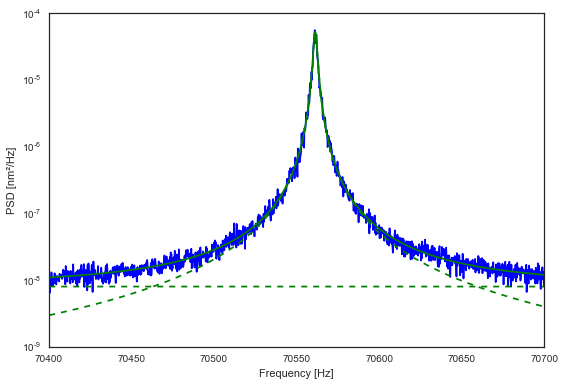

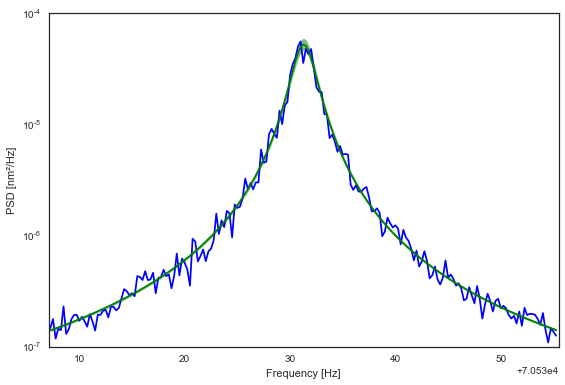

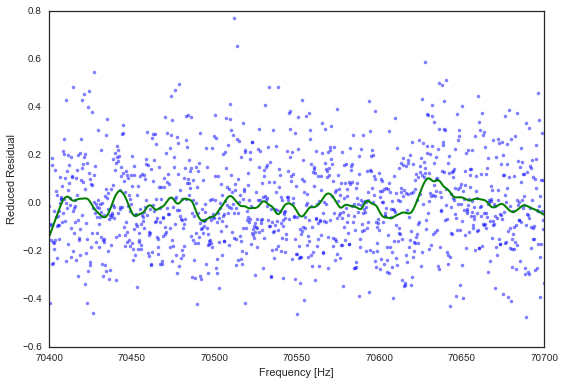

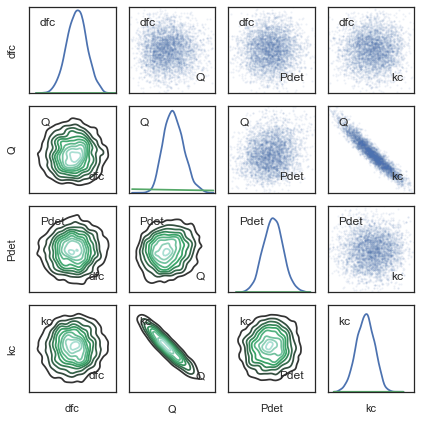

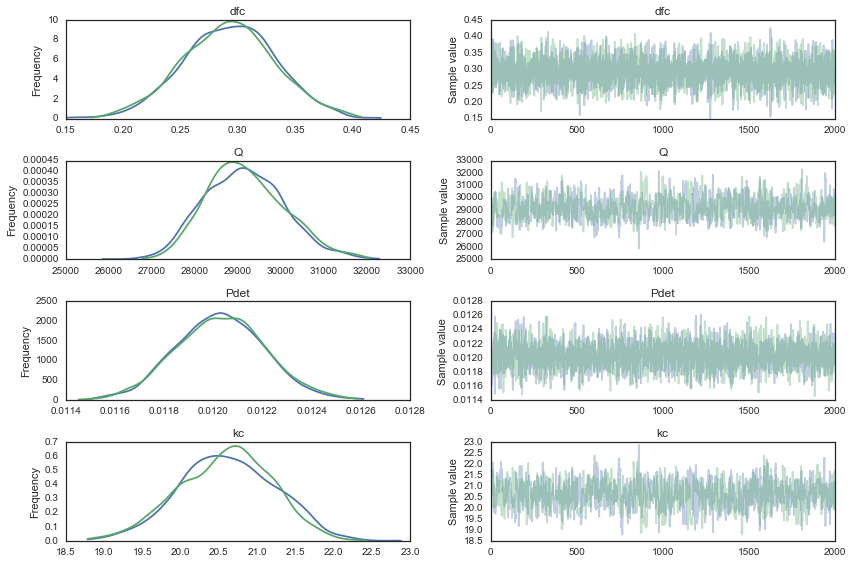

In [8]:
ppb.report(outfile='test-data', outdir='/Users/ryandwyer/ex-data')